<a href="https://colab.research.google.com/github/jhk990602/datapractice/blob/main/house_price_solution(boston).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn import preprocessing
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/drive/MyDrive/boston/train.csv')

In [3]:
df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [6]:
df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [7]:
#결측 데이터가 많은 column 순으로 데이터 확인
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/ df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total,percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [10]:
#sale price 와 상관관계가 높은 순서 출력 numeric한 column
# 1. data cleaning
# 2. sale preice와 상관관계가 높은 20개 분석하여 이상치 제거
corrmat = df.corr()
cols = corrmat.nlargest(40, 'SalePrice')['SalePrice'].index
print(cols)

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1',
       'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath',
       'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'ScreenPorch',
       'PoolArea', 'MoSold', '3SsnPorch', 'BsmtFinSF2', 'BsmtHalfBath',
       'MiscVal', 'Id', 'LowQualFinSF', 'YrSold', 'OverallCond', 'MSSubClass',
       'EnclosedPorch', 'KitchenAbvGr'],
      dtype='object')


In [13]:
#object 형식의 column 확인
print(df.select_dtypes(include = ['object']).columns.values)

['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2'
 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st'
 'Exterior2nd' 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation'
 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2'
 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' 'KitchenQual'
 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish' 'GarageQual'
 'GarageCond' 'PavedDrive' 'PoolQC' 'Fence' 'MiscFeature' 'SaleType'
 'SaleCondition']


In [14]:
#PoolQC handling
data = pd.concat([df['SalePrice'],df['PoolQC']], axis =1)

df['PoolQC'] = df['PoolQC'].replace('Ex', 'Ex')
df['PoolQC'] = df['PoolQC'].replace('Fa', 'GF')
df['PoolQC'] = df['PoolQC'].replace('Gd', 'GF')
df.loc[df.SalePrice >= 300000, 'PoolQC'] = 'Ex'
df.loc[df.SalePrice < 300000, 'PoolQC'] = 'GF'
df['PoolQC'].head()

0    GF
1    GF
2    GF
3    GF
4    GF
Name: PoolQC, dtype: object

count       54
unique       4
top       Shed
freq        49
Name: MiscFeature, dtype: object

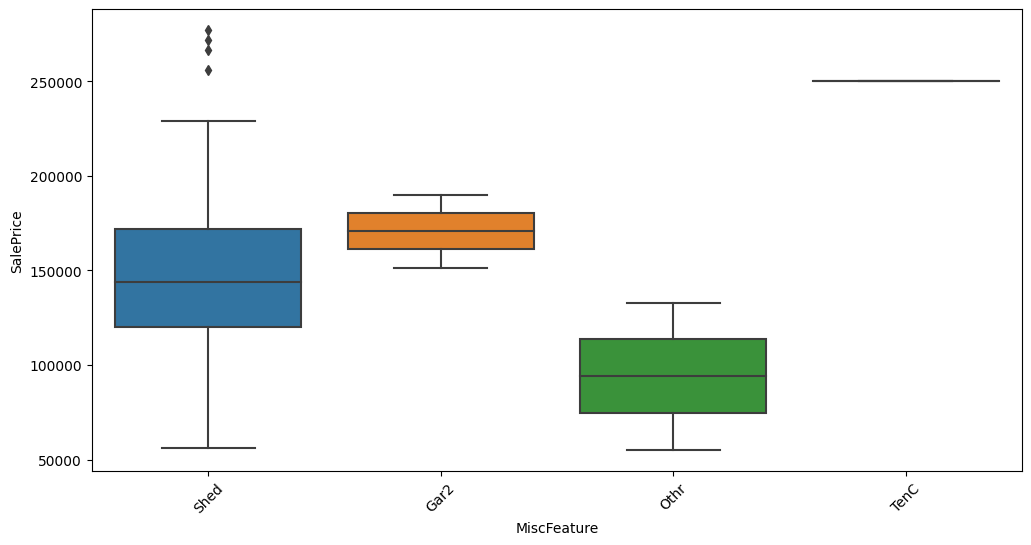

In [15]:
#MiscFeature handling
#MiscFeature가 TenC일떄 sale price가 높다
#Shed Gar2는 묶어서 Shed_Gar2로 바꾸고
#결측치는 가격이 250000일때 TenC, 140000이하일때 Othr
plt.figure(figsize=(12,6))
sns.boxplot(x='MiscFeature', y= 'SalePrice', data=df)
xt = plt.xticks(rotation= 45)
df.MiscFeature.describe()

In [16]:
df.loc[df.SalePrice >= 200000, 'MiscFeature'] = 'TenC'
df.loc[df.SalePrice < 200000, 'MiscFeature'] = 'Shed_Gar2'
df.loc[df.SalePrice < 140000, 'MiscFeature'] = 'Othr'
df.MiscFeature.head()

0         TenC
1    Shed_Gar2
2         TenC
3    Shed_Gar2
4         TenC
Name: MiscFeature, dtype: object

count          1460
unique            3
top       Shed_Gar2
freq            536
Name: MiscFeature, dtype: object

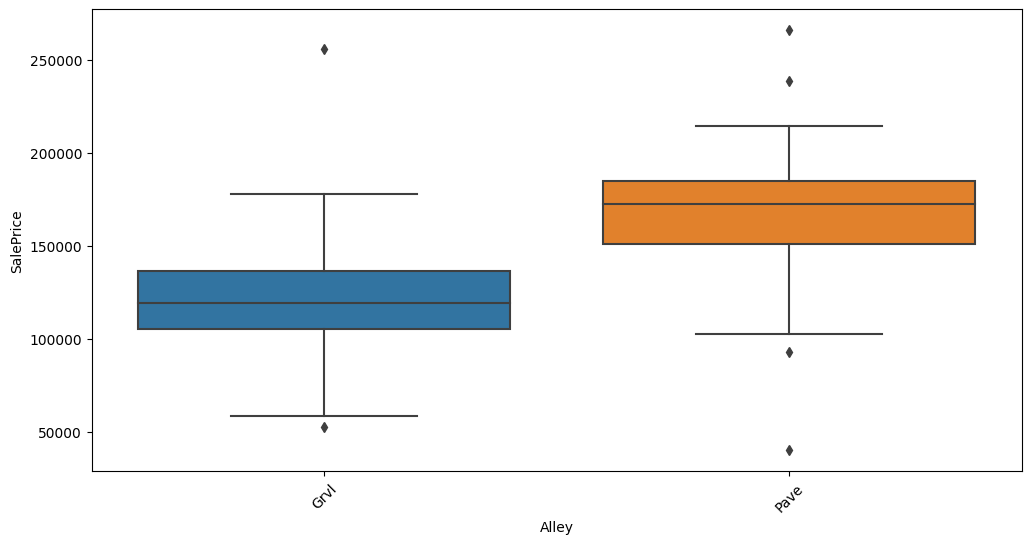

In [17]:
#Alley handling
#sale price 150000이상이면 Pave, else Grvl로 missing data 채워줌
plt.figure(figsize=(12,6))
sns.boxplot(x='Alley', y= 'SalePrice', data = df)
xt = plt.xticks(rotation=45)

df.MiscFeature.describe()

In [18]:
df.loc[df.SalePrice >= 150000, 'Alley'] = 'Pave'
df.loc[df.SalePrice < 150000, 'Alley'] = 'Grvl'
df.Alley.head()

0    Pave
1    Pave
2    Pave
3    Grvl
4    Pave
Name: Alley, dtype: object

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

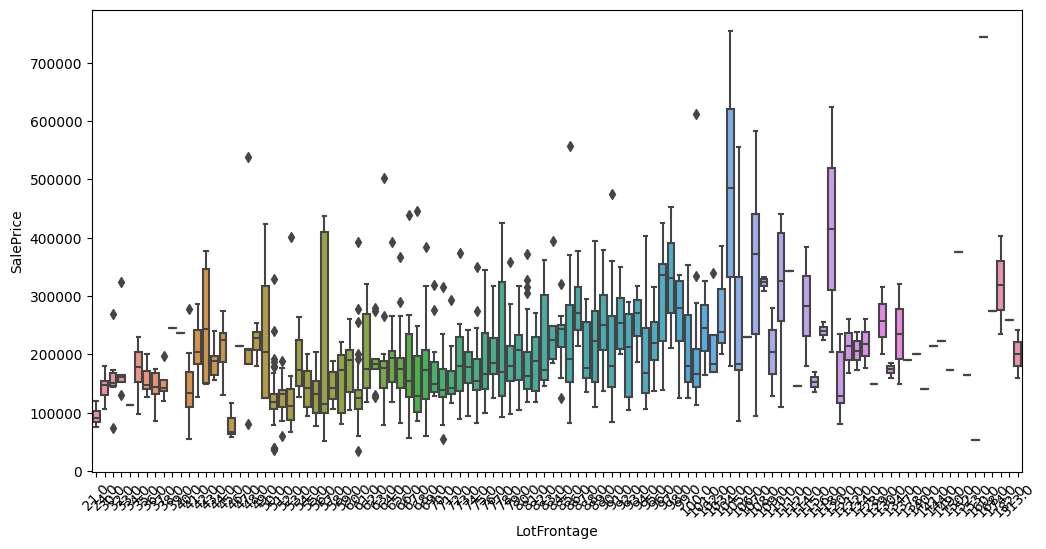

In [19]:
#LotFrontage handling
#LotFrontage 와 가격의 관계를 파악하기가 힘들다.
#따라서 LotFrontage와 상관관계가 가장 높은 column을 찾아서 결측치를 채운다.
plt.figure(figsize=(12,6))
sns.boxplot(x= 'LotFrontage', y='SalePrice', data =df)
xt = plt.xticks(rotation = 45)
df.LotFrontage.describe()

In [20]:
#LotFrontage와 상관관계가 가장 높은 column 은 1stFlrSF
cols = corrmat.nlargest(40, 'LotFrontage')['LotFrontage'].index
print(cols)
df['1stFlrSF'].describe()

Index(['LotFrontage', '1stFlrSF', 'LotArea', 'GrLivArea', 'TotalBsmtSF',
       'TotRmsAbvGrd', 'SalePrice', 'GarageArea', 'GarageCars', 'Fireplaces',
       'BedroomAbvGr', 'OverallQual', 'BsmtFinSF1', 'PoolArea', 'FullBath',
       'MasVnrArea', 'OpenPorchSF', 'BsmtUnfSF', 'YearBuilt', 'BsmtFullBath',
       'YearRemodAdd', 'WoodDeckSF', '2ndFlrSF', 'GarageYrBlt', '3SsnPorch',
       'HalfBath', 'BsmtFinSF2', 'ScreenPorch', 'LowQualFinSF', 'MoSold',
       'EnclosedPorch', 'YrSold', 'MiscVal', 'KitchenAbvGr', 'BsmtHalfBath',
       'Id', 'OverallCond', 'MSSubClass'],
      dtype='object')


count    1460.000000
mean     1162.626712
std       386.587738
min       334.000000
25%       882.000000
50%      1087.000000
75%      1391.250000
max      4692.000000
Name: 1stFlrSF, dtype: float64

In [22]:
#두 column의 scale을 맞춰주고 결측치를 채운다.
df['1stFlrSF'] = (df['1stFlrSF'] - df['1stFlrSF'].mean()) / (df['1stFlrSF'].max() - df['1stFlrSF'].min())
df['LotFrontage'] = (df['LotFrontage'] - df['LotFrontage'].mean()) / (df['LotFrontage'].max() - df['LotFrontage'].min())

df['LotFrontage'] = df['LotFrontage'] .fillna(df['1stFlrSF'])
df['LotFrontage'].head()

0    0.023437
1    0.071375
2    0.033024
3    0.007457
4    0.084159
Name: LotFrontage, dtype: float64

In [23]:
#Garage에 대한 null 값은 집에 garage가 없는 경우
#GarageCond  -범주형
#GarageType  - 범주형
#GarageYrBlt  -연속형
#GarageFinish - 범주형
#GarageQual   -범주형
#이 5가지 column이 한 set로 묶인다. 결측치를 새로운 value로 채운다.

df['GarageCond'] = df['GarageCond'].fillna('No')
df['GarageType'] = df['GarageType'].fillna('No')
df['GarageFinish'] = df['GarageFinish'].fillna('No')
df['GarageQual'] = df['GarageQual'].fillna('No')
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

In [24]:
#BsmtExposure
#BsmtFinType2
#BsmtFinType1
#BsmtCond
#BsmtQual
#이 5가지 column이 한 set로 묶인다. 결측치를 새로운 value로 채운다.
df['BsmtExposure'] = df['BsmtExposure'].fillna('dont')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('dont')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('dont')
df['BsmtCond'] = df['BsmtCond'].fillna('dont')
df['BsmtQual'] = df['BsmtQual'].fillna('dont')

In [25]:
# Fence 의 경우 price와 상관관계가 적고 결측치가 90% 를 넘기 때문에 drop 시킴
# FireplaceQu 의 경우 Fireplace 으로 설명되어 질 수 있기 때문에 drop 시킴
df = df.drop(['Fence','Id','FireplaceQu'],axis=1)

In [26]:
df = df.dropna()
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,0.023437,8450,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,0,GF,TenC,0,2,2008,WD,Normal,208500
1,20,RL,0.071375,9600,Pave,Pave,Reg,Lvl,AllPub,FR2,...,0,0,GF,Shed_Gar2,0,5,2007,WD,Normal,181500
2,60,RL,0.033024,11250,Pave,Pave,IR1,Lvl,AllPub,Inside,...,0,0,GF,TenC,0,9,2008,WD,Normal,223500
3,70,RL,0.007457,9550,Pave,Grvl,IR1,Lvl,AllPub,Corner,...,0,0,GF,Shed_Gar2,0,2,2006,WD,Abnorml,140000
4,60,RL,0.084159,14260,Pave,Pave,IR1,Lvl,AllPub,FR2,...,0,0,GF,TenC,0,12,2008,WD,Normal,250000


###이상치제거\


*   그래프 시각화

<Axes: xlabel='YearBuilt', ylabel='SalePrice'>

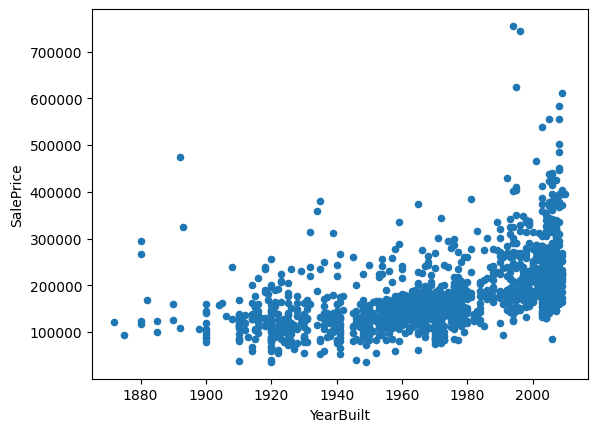

In [28]:
#시각화

var = 'YearBuilt'
data = pd.concat([df['SalePrice'],df[var]],axis=1)

data.plot.scatter(x=var, y='SalePrice', ylim=(0.800000))